In [1]:
import numpy as np
import pandas as pd
import re, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn

import sys
sys.path.append("..")
import time
from huginn.demo_console import demo_console

In [2]:
cl = demo_console()

keyword: Steve Jobs
[{'mid': '/m/06y3r', 'title': 'Steve Jobs', 'type': 'American business magnate'}, {'mid': '/m/012hyvv1', 'title': 'Steve Jobs', 'type': 'Film'}, {'mid': '/m/0h3xrzh', 'title': 'Steve Jobs', 'type': 'Book by Walter Isaacson'}, {'mid': '/m/0j7j4ls', 'title': 'Jobs', 'type': 'Film'}, {'mid': '/m/051dqy7', 'title': 'Steve Jobs', 'type': 'Book by Jeffrey S. Young'}]
Enter the mid you are interested in: /m/06y3r


In [3]:
cl.get_anomalies(k = 6, halflife_std = 10, halflife_mean = 1)

DatetimeIndex(['2007-09-01', '2011-10-01'], dtype='datetime64[ns]', name='date', freq=None)

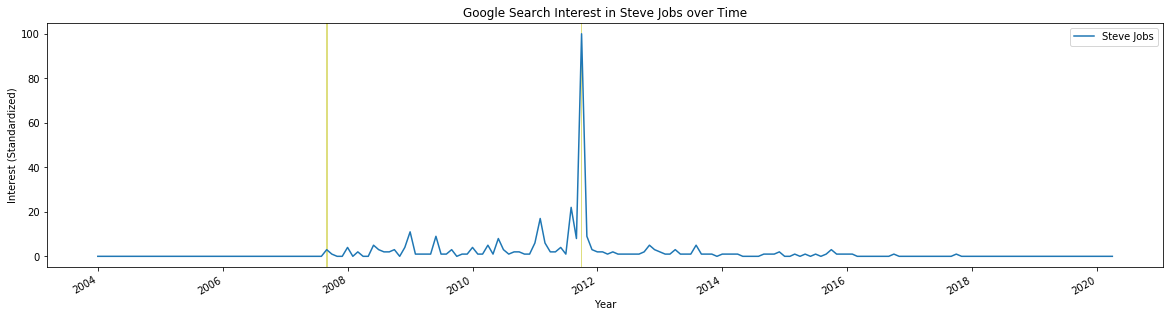


        If you are not happy with these anomalies, you can call the method 'get_anomalies' and
        specify the function to get anomalies:
        - method = 'constant' with parameter k (set to 1 by default)
        - method = 'rolling' with parameters lookback_mean, lookback_std and k (set to 1, 10, 1 by default)
        - method = 'ewm' with parameters halflife_mean, halflife_std and k(set to 1,10,1 by default) [default method]
        


In [4]:
cl.plot_interest_with_anomalies()

In [5]:
cl.get_info(num_links = 10)

You asked for 20 articles.
19 articles about Steve Jobs were found.
47% of found articles could have been scrapped


In [6]:
print(dir(cl))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'anomalies', 'anomalies_formatted', 'anomaly_plot', 'articles', 'check_got_anomalies', 'check_got_articles', 'check_got_ldamodel', 'get_anomalies', 'get_info', 'get_summary', 'gpt2', 'images', 'interest', 'mid', 'model_lda', 'name', 'plot_interest', 'plot_interest_with_anomalies', 'titles', 'urls']


In [2]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


In [3]:
df.head(15)

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space
5,From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...,16,talk.politics.guns
6,From: bmdelane@quads.uchicago.edu (brian manni...,13,sci.med
7,From: bgrubb@dante.nmsu.edu (GRUBB)\nSubject: ...,3,comp.sys.ibm.pc.hardware
8,From: holmes7000@iscsvax.uni.edu\nSubject: WIn...,2,comp.os.ms-windows.misc
9,From: kerr@ux1.cso.uiuc.edu (Stan Kerr)\nSubje...,4,comp.sys.mac.hardware


In [4]:
data = df.content.values.tolist()[0:100]
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


<>:3: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \s
<ipython-input-4-23aa64077bc2>:3: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
<ipython-input-4-23aa64077bc2>:5: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [6]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['where s thing subject car nntp post host line wonder out could enlighten car see other day door sport car look late early call door really small addition front bumper separate rest body know can tellme model name engine specs year production where car make history info funky look car mail thank bring neighborhood lerxst', 'poll final call summary final call clock report acceleration post fair number brave soul upgrade si clock oscillator share experience poll send brief message detail experience procedure top speed attain cpu rate speed add card adapter heat sink hour usage day floppy disk functionality floppy especially request will summarize next day so add network knowledge base do clock upgrade answer poll thank']


In [7]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [8]:
# Materialize the sparse data
data_dense = data_vectorized.todense()
# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  17.50588235294118 %


In [9]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [10]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -11037.304305704733
Perplexity:  184.67242798696623
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [11]:
# Define Search Param
search_params = {'n_components': [10], 'learning_decay': [.5]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [12]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -2741.314174249789
Model Perplexity:  96.22924732197038


In [13]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(lda_output, columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.round(2)

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.01,0.01,0.01,0.01,0.01,0.01,0.21,0.01,0.75,0.01,8
Doc1,0.01,0.01,0.01,0.48,0.01,0.01,0.42,0.01,0.01,0.01,3
Doc2,0.00,0.00,0.00,0.00,0.17,0.00,0.00,0.00,0.42,0.39,8
Doc3,0.01,0.01,0.01,0.14,0.01,0.01,0.01,0.01,0.01,0.82,9
Doc4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.96,9
...,...,...,...,...,...,...,...,...,...,...,...
Doc95,0.93,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0
Doc96,0.00,0.00,0.00,0.00,0.00,0.00,0.97,0.00,0.00,0.00,6
Doc97,0.30,0.01,0.01,0.01,0.01,0.49,0.01,0.01,0.17,0.01,5
Doc98,0.02,0.02,0.02,0.02,0.02,0.02,0.16,0.02,0.02,0.70,9


In [14]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,8,23
1,5,18
2,9,16
3,4,11
4,0,10
5,1,8
6,6,6
7,3,4
8,7,2
9,2,2


In [15]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
5      32.420952   8.115230       1        1  26.002691
8       0.648955  71.707100       2        1  16.127955
9      71.019684   9.971006       3        1  15.987634
6       3.785981  33.185135       4        1  13.185283
4     -42.666500  -9.222070       5        1  11.753671
0      -3.621689 -43.526516       6        1   7.869765
1      -3.632402  -4.171708       7        1   3.080773
3     -36.584400  35.804413       8        1   2.939480
7      44.391380  50.615383       9        1   1.988670
2      40.235809 -31.591665      10        1   1.064078, topic_info=      Term       Freq      Total Category  logprob  loglift
72   thing  35.000000  35.000000  Default  30.0000  30.0000
77     use  83.000000  83.000000  Default  29.0000  29.0000
50  people  60.000000  60.000000  Default  28.0000  28.0000
54    post  68.000000  68.000000  Default  27.0000  27.0000
84    year  56.000000  56.000000  Default  26.0000  26.0000
..     ...        ...        ...      ...      ...      ...
9     case   0.095763  14.376439  Topic10  -5.4596  -0.4684
62   right   0.095763  23.143203  Topic10  -5.4596  -0.9445
81    work   0.095763  25.849599  Topic10  -5.4596  -1.0551
78    want   0.095763  23.212532  Topic10  -5.4596  -0.9475
15     day   0.095763  25.989458  Topic10  -5.4596  -1.0605

[401 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.957099    agree
1         1  0.329667  article
1         3  0.407236  article
1         4  0.058177  article
1         5  0.058177  article
...     ...       ...      ...
84        1  0.123902     year
84        3  0.053101     year
84        4  0.761113     year
84        5  0.017700     year
84        8  0.017700     year

[416 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 9, 10, 7, 5, 1, 2, 4, 8, 3])

In [16]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,agree,article,ask,available,bad,base,bit,buy,car,case,...,try,turn,use,want,way,window,work,world,write,year
Topic0,0.100000,6.059567,1.099965,3.898603,0.100000,0.100000,1.783842,3.100011,0.100000,1.099993,...,0.100011,0.10000,3.457011,2.935529,2.247784,0.100004,3.318662,6.806613,5.861974,0.100007
Topic1,0.100000,0.100000,0.100029,2.100026,0.100000,0.100000,1.100003,0.100000,0.100000,1.952167,...,0.100000,0.10000,2.737337,0.100000,0.100000,0.100000,0.100000,0.100000,2.100033,0.100005
Topic2,0.100000,0.100000,1.100054,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.10000,2.100128,0.100000,0.100000,0.100000,0.100000,0.100000,1.100073,0.100000
Topic3,0.100000,1.617981,0.100008,0.100000,0.100000,0.100042,0.100000,0.100000,1.099954,0.100000,...,0.100000,1.10001,0.100034,0.100024,0.100000,0.100000,0.100000,0.100068,1.171494,1.322743
Topic4,0.100003,3.071548,0.100010,1.412283,7.624149,1.099992,10.135576,2.036387,0.100004,0.100002,...,11.549061,0.10003,19.050755,4.510449,2.018247,3.679909,7.355103,0.100007,7.865750,1.197521


In [17]:
df_topic_keywords.sum(axis = 1)

Topic0    175.757110
Topic1     70.987903
Topic2     23.500966
Topic3     65.623520
Topic4    257.111731
Topic5    569.897505
Topic6    285.811639
Topic7     42.903070
Topic8    366.815847
Topic9    341.590708
dtype: float64

In [18]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,line,subject,post,host,world,reply,nntp,course,article,write,fact,note,right,come,need
Topic 1,post,line,note,nntp,know,reply,use,include,hard,organization,thank,write,available,end,subject
Topic 2,know,use,good,distribution,write,line,file,ask,include,come,old,thing,post,thank,subject
Topic 3,possible,information,post,thank,day,distribution,nntp,subject,just,article,include,major,need,year,host
Topic 4,problem,use,line,try,memory,bit,say,think,write,computer,bad,work,thank,information,run
Topic 5,people,write,line,post,say,use,article,think,time,way,hand,agree,want,right,let
Topic 6,year,car,buy,make,close,use,end,new,ask,include,summary,old,base,thing,service
Topic 7,thing,people,great,post,write,think,say,use,base,course,man,time,point,service,article
Topic 8,use,line,window,help,run,car,post,know,subject,need,look,nntp,available,write,number
Topic 9,think,write,article,know,line,say,really,subject,question,people,time,post,thing,look,come


In [19]:
ids = list(map(lambda x : int(x[3:]), list(df_document_topic[df_document_topic['dominant_topic']==4].index)))
data_to_summarize = [data[i] for i in ids]
len(data_to_summarize)

11

In [23]:
from transformers import pipeline

def run_summary(gpt2_input):
    summarizer = pipeline("summarization")
    return summarizer(gpt2_input, max_length = 10)
test = """
Steve Jobs died years ago. But for devoted fans of the iconic Apple co-founder, it seems like just yesterday that Jobs stepped away from his role as Apple’s chief executive to seek treatment for the rare pancreatic cancer that would eventually kill him. But that begs the question: When did Steve Jobs die? And what were his last words?

Read on to get all the details on Jobs’ untimely death, what he regretted about the choices he made during his life, and what his sister said were Steve Jobs’ last words.
Steve Jobs developed a rare form of pancreatic cancer
Steve Jobs opens the Apple Worldwide Developers conference in 2005

Steve Jobs opened the Apple Worldwide Developers conference in 2005. | David Paul Morris/ Getty Images

WebMD reports that if Steve Jobs had developed the most common form of pancreatic cancer, adenocarcinoma, he would likely have died soon after his 2003 diagnosis. Instead, he had an unusual form of pancreatic cancer known as a neuroendocrine tumor or islet cell carcinoma, which typically has a much better prognosis. Islet cells — the hormone-producing cells of the pancreas — develop cancers that are highly treatable and often curable. In 2004, Jobs underwent surgery to remove the tumor.

Jobs is said to have undergone a Whipple procedure. That usually involves removing the head of the pancreas, part of the bile duct, the gallbladder, and the first part of the small intestine. Years later, in 2009, he received a liver transplant. That would have meant that cancer had spread to his liver. However, cancer can recur even after the transplant. And because the patient is on immune-suppressing anti-rejection drugs, there’s little that doctors can do. That’s what happened to Steve Jobs.
He regretted his treatment decisions

The Telegraph reports that Steve Jobs told his biographer that he regretted spending time trying to treat his cancer with alternative medicine. Jobs delayed operations and chemotherapy for nine months after his diagnosis in 2003 to try to treat his cancer without surgery. Biographer Walter Isaacson explained, “I think he felt: if you ignore something you don’t want to exist, you can have magical thinking. It had worked for him in the past. He would regret it.”

Jobs’ wife, Laurene Powell, told Isaacson, “The big thing was he really was not ready to open his body. It’s hard to push someone to do that.” When Jobs did agree to traditional treatment, he had his DNA sequenced at the cost of $100,000. That enabled doctors to specifically target treatment to the particular molecular pathways that were defective in his body. But eventually, surgery revealed that cancer had spread beyond the pancreas to his liver.
But the tumor could have spread even with earlier treatment
Steve Jobs introduces the iPad 2

Steve Jobs waves to the crowd. | Justin Sullivan/ Getty Images

Steve Jobs might have regretted the decision to try acupuncture, a vegan diet, herbs, and juices before operating on his cancer. But The New York Times notes that it’s impossible to know whether that would have stopped his cancer from eventually killing him. Dean Ornish, one of Jobs’ doctors, told the Times, “No one can say whether or not having surgery earlier would have made any difference because of the possibility of micrometastases.”

Micrometastases are tiny cancers that form in various organs when a tumor starts to spread around the body. The Times notes, “Dr. Ornish’s comment means that in theory, Mr. Jobs’ tumor could already have spread invisibly to his liver by the time it was first diagnosed. If it had, operating earlier probably would not have made a difference.” Another doctor explained that among patients with this kind of tumor, “when they are first found on a scan, about 60 percent of the time it’s already metastasized to the liver.”
When did Steve Jobs die?

Harvard Health reports that Steve Jobs died on October 5, 2011, “almost exactly eight years after his cancer was discovered incidentally on a CT scan of his kidneys (the pancreas is near the left kidney).” Jobs got the CT scan at the recommendation of his urologist, who was concerned about kidney stones he’d had several years earlier. Jobs’ liver transplant didn’t preclude his cancer from recurring. His liver was full of cancer when doctors removed it. That means that cancer had likely already spread outside the pancreas and liver at the time of the transplant.

When Steve Jobs died on October 5, 2011, he was just 56 years old. He had taken medical leave from Apple starting in January that year, CNN reports. And he stepped down as Apple’s chief executive in August 2011, saying he could “no longer meet (his) duties and expectations.” Jobs was survived by his wife of 20 years, Laurene, and four children, including one — Lisa Brennan-Jobs — from a prior relationship.
"""
run_summary(test)

Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/facebook/bart-large-cnn/modelcard.json' to download model card file.
Creating an empty model card.


[{'summary_text': 'Apple co-founder Steve Jobs died,'}]